# Casos confirmados de tuberculose no Brasil

Este *notebook* apresenta uma breve análise sobre os números relativos a casos de tuberculose no Brasil entre os anos de 2001 e 2019. Os dados foram obtidos através do sistema dataSUS.

Vamos utilizar as bibliotecas *statsmodels* e *pmdarima* para extrair estatísticas e outras características relevantes dessa série temporal, assim como fazer previões sobre seu comportamento futuro.

Utilizamos as bibliotecas tradicionais de *Data Science*, assim como a biblioteca menos conhecida *pyjanitor* (importada apenas como *janitor*), que acrescenta métodos úteis aos *DataFrames* do *pandas*.

In [1]:
from datetime import datetime
from pathlib import Path

import colorcet as cc
import janitor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pmdarima as pm
from pmdarima.metrics import smape
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.tsa.api as tsa

## Preparando os dados

Vamos usar aqui um conjunto de dados de casos confirmados de tuberculose ao longo dos anos, obtido através do portal *Data SUS* (http://tabnet.datasus.gov.br/cgi/tabcgi.exe?sinannet/cnv/tubercbr.def). É importante notar que o arquivo obtido usa a codificação *latin1* e é separado por ponto-e-vírgula. Na sua leitura, ignoramos o cabeçalho e o rodapé. Além disso, limpamos os nomes das colunas (*clean_names*) e descartamos a última coluna (*select_columns*), que apenas dá a soma de casos a cada ano (o parâmetro *invert* significa que a coluna indicada deve ser excluída).

In [2]:
dados = (
    pd.read_csv(
        Path('../dados/A105425189_28_143_208.csv'),
        encoding='latin1',
        sep=';',
        skiprows=3,
        skipfooter=17,
    )
    .clean_names()
    .select_columns(['total'], invert=True) 
)


Vemos que os dados se apresentam em uma forma pouco conveniente para a análise. Existe uma coluna para cada ano e outras 12 colunas para cada mês. Para fazermos uma análise adequada, precisamos que a tabela de dados apresente uma coluna para as datas na forma *ano-mês* e outra coluna para o número de casos confirmados.

In [3]:
dados

,ano_diagnostico,jan,fev,mar,abr,mai,jun,jul,ago,set,out,nov,dez
0,2001,8088,6542,8095,7305,7656,6805,6987,8065,6697,7524,6874,6627
1,2002,8013,7346,7961,8771,7784,6713,7746,8330,7654,8200,7532,6809
2,2003,8115,7985,7474,7975,8024,7082,7949,7585,8136,8521,7624,7303
3,2004,7574,6743,8574,8089,7763,7314,7825,8232,7901,8016,7753,7196
4,2005,7432,6748,8441,7958,8019,7781,7282,8391,7690,7186,7587,7541
5,2006,7385,6687,8132,6804,7593,6984,7101,7722,6793,7005,6674,6151
6,2007,7342,6204,8115,7266,7368,6591,7184,7564,6712,7465,6695,6094
7,2008,7355,6646,7278,7612,6895,6929,7688,7797,7631,7564,6799,6574
8,2009,7113,6452,8146,7514,7168,6702,7443,7368,7388,7285,7016,6723
9,2010,6912,6403,8308,7049,6973,6621,7128,7389,7165,7210,7047,7176


Em primeiro lugar, é bom que façamos a conversão das abreviações dos nomes dos meses para seus números. Isso vai facilitar o trabalho mais pra frente (especialmente considerando que vamos utilizar bibliotecas em inglês). Para isso, definimos um dicionário que mapeia as abreviações nos números.

In [4]:
meses = {
    'jan': '01',
    'fev': '02',
    'mar': '03',
    'abr': '04',
    'mai': '05',
    'jun': '06',
    'jul': '07',
    'ago': '08',
    'set': '09',
    'out': '10',
    'nov': '11',
    'dez': '12',
}


Com isso, podemos usar a função *pd.melt* para criar uma coluna de datas que satisfaça as condições que desejamos. A sequência de operações é
* (*pd.melt*) "Derreter" o *DataFrame* de forma a ter uma coluna para os meses;
* (*replace*) Substituir as abreviaturas pelos números usando o dicionário definido;
* (*sort_values*) Ordenar o *DataFrame* pelo ano e pelo mês;
* (*concatenate_columns*) Juntar os valores dos anos e dos meses em uma única coluna que se chamará *data*;
* (*select_columns*) Selecionar apenas as colunas de data "compilada" e de número de casos;
* (*reset_index*) Reorganizar o índice do *DataFrame*.

O novo *DataFrame* é chamado de *serie_temp*.

In [5]:
serie_temp = (
    pd.melt(
        dados,
        id_vars='ano_diagnostico',
        var_name='mes',
        value_name='casos',
    )
    .replace(meses.keys(), meses.values())
    .sort_values(by=['ano_diagnostico', 'mes'])
    .concatenate_columns(
        column_names=['ano_diagnostico', 'mes'],
        new_column_name='data',
        sep='-',
    )
    .select_columns(['data', 'casos'])
    .reset_index(drop=True)
)

In [6]:
serie_temp

,data,casos
0,2001-01,8088
1,2001-02,6542
2,2001-03,8095
3,2001-04,7305
4,2001-05,7656
...,...,...
223,2019-08,8239
224,2019-09,8143
225,2019-10,8592
226,2019-11,7615


Da forma como criamos a coluna de datas, estas estão representadas como *strings*. É conveniente para fins de manipulação dos dados que elas sejam convertidas para o tipo especificamente usado para datas. Fazemos isso com a função *pd.to_datetime*.

In [7]:
serie_temp['data'] = pd.to_datetime(serie_temp['data'])

Podemos ver que as datas são agora do tipo *datetime64[ns]* e os casos são do tipo *int64*.

In [8]:
serie_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228 entries, 0 to 227
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   data    228 non-null    datetime64[ns]
 1   casos   228 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 3.7 KB


Vamos também identificar as datas como os índices do *DataFrame* para facilidade de manipulação.

In [9]:
serie_temp = serie_temp.set_index('data')

## Analisando a série temporal

Uma visualização simples da série temporal nos mostra que o número de casos oscila muito ao longo do tempo. Apenas olhando esse gráfico é difícil de extrair qualquer tipo de informação útil.

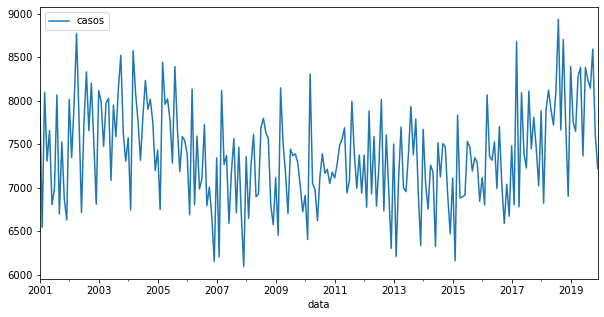

In [10]:
fig, ax = plt.subplots(figsize=(10, 5))

serie_temp.plot(ax=ax)

plt.show()

Para tentar obter uma visualização menos ruidosa, e portanto mais fácil de analisar, podemos lançar mão do noção de médias móveis. Utilizando esse conceito, nós substituímos o número de casos a cada instante de tempo pela média do número de casos nos *n* instantes anterios. Devemos escolher um valor para *n* tal que a curva resultante seja suavizada, porém sem perder informação em excesso.

As séries do *pandas* oferecem o método *rolling*, que tem justamente a funcionalidade de considerar intervalos sequenciais de dados na forma que queremos. Basta então apenas passar a função desejada, que no nosso caso é a média, *mean*.

Do gráfico abaixo, podemos ver que a série com média móvel de 12 meses produz a visualização mais fácil de se interpretar globalmente.

Podemos ver que o número de casos de tuberculose manteve um patamar de cerca de 7700 casos desde o final de 2002 até o meio de 2005, quando caiu para cerca de 7000. Deste momento até 2016, o número de casos teve oscilações maiores, mas sempre entre 7000 e 7300 casos. Em 2017, os números voltaram a subir, aparentemente alcançando um patamar ainda maior, de cerca de 8000 casos.

No entanto, é importante lembrar que, apesar de ser de grande valor para a análise de séries temporais, o recurso de médias móveis pode acabar produzindo artifícios nos dados e portanto deve ser interpretado com cuidado.

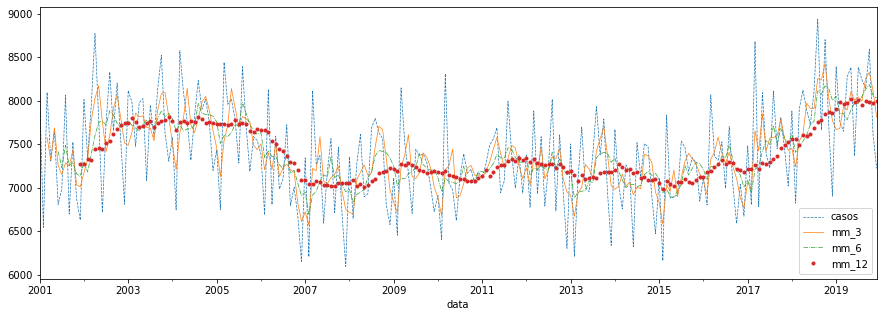

In [11]:
medias_moveis = serie_temp.add_columns(
    mm_3=serie_temp['casos'].rolling(3).mean(),
    mm_6=serie_temp['casos'].rolling(6).mean(),
    mm_12=serie_temp['casos'].rolling(12).mean(),
)

fig, ax = plt.subplots(figsize=(15, 5))

medias_moveis.plot(ax=ax, lw=.7, style=['--', '-', '-.', '.'])

plt.legend()
plt.show()

Para tentar encontrar alguma sazonalidade na série temporal, uma opção é criar uma visualização com curvas individuais para cada ano. Dessa forma, podemos comparar os números de casos em um determinado mês para anos diferentes. O próprio *pandas* possui uma funcionalidade para a construação dessa visualização com facilidade. No entanto, precisamos transformar nosso *DataFrame* em uma forma, também conhecida como "forma larga," semelhante à forma dos dados originais. Em primeiro lugar, usando os métodos de *datetime* do *pandas*, criamos uma coluna para o valor do mês e outra para o valor do ano. Depois disso, podemos usar o método *pivot* para fazer com que o índice do *DataFrame* corresponda ao mês e cada coluna represente um ano.

Vale notar que usamos a biblioteca *colorcet* para personalizar as cores das curvas.

Analisando esse gráfico, percebemos uma aparente tendência de subida no número de casos nos meses de março (3), agosto (8) e outubro (10), quando comparados com seus meses vizinhos.

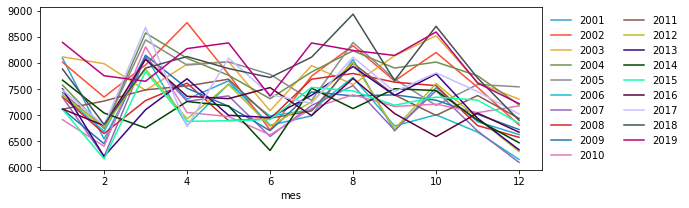

In [12]:
st_forma_larga = serie_temp.copy()
st_forma_larga['ano'] = st_forma_larga.index.year
st_forma_larga['mes'] = st_forma_larga.index.month
st_forma_larga = st_forma_larga.pivot(index='mes', columns='ano', values='casos')

fig, ax = plt.subplots(figsize=(9, 3))

st_forma_larga.plot(
    ax=ax,
    color=cc.glasbey_hv,
)

ax.legend(
    loc='center left',
    bbox_to_anchor=(1, .5),
    frameon=False,
    ncol=2,
)

plt.show()

A biblioteca *statsmodels* oferece uma ferramenta para a realização de uma decomposição sazonal que possibilita de tendência e periodicidade de uma forma mais objetiva. Usando esta função, vemos que a tendência (*trend*) é muito semelhante à média móvel de 12 meses que já obtivemos, e que há de fato alguns picos sazonais ao longo do ano, apesar de serem muito fracos. Apesar disso, ainda existe um resíduo razoável que acrescenta ruído à série, chegando a mais de 10% do seu valor nos casos mais extremos.

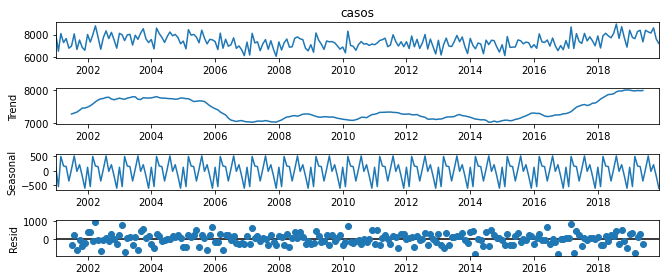

In [13]:
decomposicao = tsa.seasonal_decompose(serie_temp['casos'])


decomposicao.plot().set_figwidth(10)

Considerando um único ano da componente sazonal, podemos confirmar nossa observação anterior de que existem picos nos meses de março, agosto e outubro. Além disso, existe um vale pronunciado no mês de junho.

<AxesSubplot:xlabel='data'>

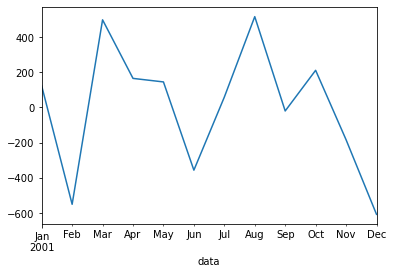

In [14]:
decomposicao.seasonal.loc['2001-01':'2001-12'].plot()

As funções de autocorrelação proveem um valioso mecanismo para analisar a estacionariedade de uma série temporal. Para entender isso melhor, imagine que geremos uma nova série a partir dos dados originais, apenas transladando os valores temporalmente. Em outras palavras, a nova série será idêntica à original, mas com seus valores atrasados no tempo. Se a série original se repete periodicamente, é possível que ela apresente uma boa correlação com a série defasada, ou seja, seus valores seriam "parecidos." Isso será verdade desde que o atraso utilizado para gerar a nova série coincida com o período da série original. Intuitivamente, a série temporal possui partes que se repetem e que podem se "encaixar" caso seja deslocada exatamente de um múltiplo do "tamanho" de cada uma dessas parte.

A biblioteca *statsmodels* também fornece funções que nos ajudam a avaliar a autocorrelação de séries temporais.

O gráfico da função de autocorrelação mostra o valor da correlação, no eixo *y*, em função da defasagem, no eixo *x*. No nosso caso, a defasagem é dada em meses. Vemos que para uma defasagem de 0, a correlação vale 1. Isso sempre é verdade, já que uma série com defasagem de 0 é equivalente à série original, e uma correlação perfeita apresenta o valor 1.

Para os outros atrasos, os valores mais altos indicam uma correlação mais forte. O gráfico destaca uma correlação forte quando o atraso é de 12 meses, ou 1 ano. Isso quer dizer que a série temporal apresenta uma sazonalidade anual significativa. Esse resultado é bastante relevante, já que apenas olhando o gráfico da série temporal, esse fato não é imediatamente óbvio (apesar de podermos inferir isso a partir da decomposição sazonal, a função de autocorrelação deixa a ideia mais clara).

Outros valores de correlação mais alta aparecem para atrasos pequenos, o que sugere simplesmente que a série temporal não possui oscilações muito bruscas em geral. Em outras palavras, o valor da série em um tempo é sempre razoavelmente próximo do valor nos tempos vizinhos.

Também podemos ver uma correlação razoavelmente alta para o atraso de 24 meses, ou 2 anos. Essa correlação é mais baixa do que no caso de apenas 1 ano, o que indica que a correlação se perde ao longo do tempo.

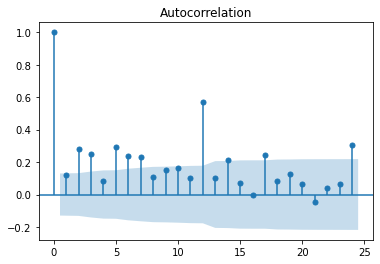

In [15]:
plot_acf(serie_temp['casos']);

É importante salientar que quando calculamos a autocorrelação de uma série temporal, obtemos um resultado que representa o quanto o seu valor em um determinado instante pode ser previsto tomando como referência seus valores em todos os instantes anteriores. Porém, em algumas situações, podemos querer isolar o efeito de um único instante de tempo sobre o outro, desconsiderando todos os pontos que estão "no meio do caminho." Isso é o que a função de autocorrelação parcial faz.

No gráfico podemos ver que a correlação com o atraso de 12 meses permanece destacada, o que significa que o número de casos em janeiro, por exemplo, pode ser amplamente predito pelo número de casos no janeiro anterior, independentemente de como tenha sido o resto do ano.

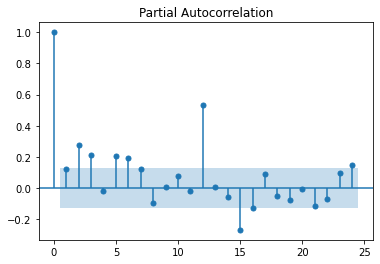

In [16]:
plot_pacf(serie_temp['casos']);

## Modelos preditivos

Um dos modelos matemáticos mais utilizados para fazer previsões de séries temporais é o chamado de *ARIMA* (*Auto-Regressive Integrated Moving Average*). Esse modelo considera que os valores futuros de uma série temporal podem ser descritos como uma combinação linear de seus valores passados (da parte auto-regressiva, *AR*), assim como pressupõe que os erros correntes são combinações dos erros anteriores (da parte de média móvel, *MA*). Além disso, os desvios a partir estacionariedade são compensados ponto a ponto (da parte integrada, *I*).

Apesar de ser um modelo bastante simples do ponto de vista matemático, ele se mostra bastante poderoso, sendo capaz de realizar excelentes previsões quando devidamente ajustado.

Para que possamos implementar um modelo ARIMA, é necessário que a série seja estacionária. Isso quer dizer que sua média deve ser aproximadamente constante ao longo do tempo.

Para definir se a série é estacionária, vamos observar o seu gráfico, reproduzido novamente abaixo. Podemos ver que seus valores oscilam de forma aparentemente aleatória, mas sempre se mantendo em torno da média, representada pela linha tracejada. Esse comportamento sugere que a série seja de fato estacionária.

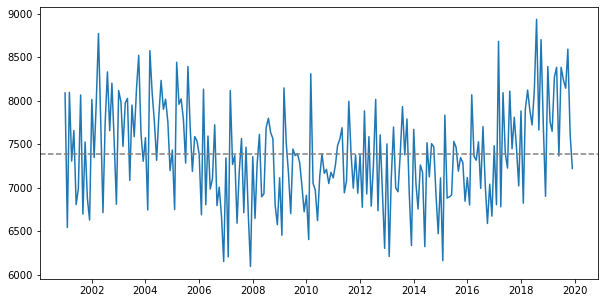

In [17]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(serie_temp['casos'])
ax.axhline(serie_temp['casos'].mean(), color='gray', ls='--')

plt.show()

No caso de séries não estacionárias, o modelo ARIMA propõe uma diferenciação ponto-a-ponto dos valores. A ideia é que essa diferenciação possa remover as fontes de tendências. Vamos aplicar esse método duas vezes e comparar as séries obtidas com a original.

Como já argumentamos, a série original (primeira linha) aparenta ser estacionária. Sua função de autocorrelação cai rapidamente para valores próximos de 0 (o que é esperado em séries estacionárias: existe pouca correlação entre um valor da série e o seguinte).

Tomando a primeira diferença (segunda linha), vemos num primeiro momento que a série parece ser ainda mais estacionária. Porém, olhando com mais atenção, vemos que existe uma alternação muito acentuada entre valores positivos e negativos, o que reflete na sua autocorrelação de atraso 1 ser muito negativa. Em outras palavras, a autocorrelação muito negativa significa que a série tende fortemente a "pular" de um lado da média para o outro, o que é pouco provável em um processo aleatório. Isso em geral indica que a séria foi diferenciada em exagero.

A segunda diferença (terceira linha), apresenta as mesmas características da primeira, porém mais acentuadas.

Com essas observações em mente, concluímos que é provável que a melhor opção seja *não diferenciar a série*.

[]

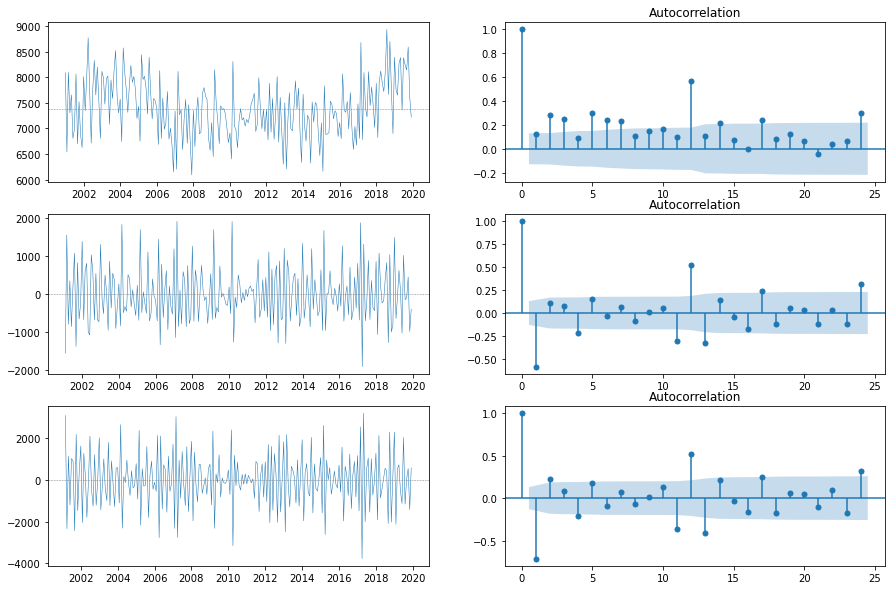

In [18]:
fig, axes = plt.subplots(3, 2, figsize=(15, 10))

axes[0, 0].plot(serie_temp['casos'], lw=.5)
axes[0, 0].axhline(serie_temp['casos'].mean(), color='gray', ls= '--', lw=.5)
plot_acf(serie_temp['casos'], ax=axes[0, 1])

diff_1 = serie_temp['casos'].diff()
axes[1, 0].plot(diff_1, lw=.5)
axes[1, 0].axhline(diff_1.mean(), color='gray', ls= '--', lw=.5)
plot_acf(diff_1.dropna(), ax=axes[1, 1])

diff_2 = diff_1.diff() 
axes[2, 0].plot(diff_2, lw=.5)
axes[2, 0].axhline(diff_2.mean(), color='gray', ls= '--', lw=.5)
plot_acf(diff_2.dropna(), ax=axes[2, 1])

plt.plot()


Vamos agora dividir nossos dados em uma série de treino e uma de teste. A série de teste, que será constituída dos últimos 12 meses dos nossos dados será usada para avaliarmos o nosso modelo. Os primeiros meses serão usados para o treino.

In [19]:
serie_temp

,casos
data,
2001-01-01,8088
2001-02-01,6542
2001-03-01,8095
2001-04-01,7305
2001-05-01,7656
...,...
2019-08-01,8239
2019-09-01,8143
2019-10-01,8592


In [20]:
dados_treino = serie_temp.iloc[:-12, :2]
dados_teste = serie_temp.iloc[-12:, :2]

Com os dados de treino e teste, fazemos o ajuste do modelo ARIMA da biblioteca *statsmodels*.

O parâmetro *p* da parte auto-regressiva pode ser obtido através da análise da função de autocorrelação parcial. O modelo AR pressupõe que o valor da série temporal num instante *t* é linearmente dependente dos *p* instantes anteriores, de *t*-1 até *t*-*p*. Como já vimos, a PACF nos mostra quais os atrasos que possuem forte correlação com a série original. Dessa forma, o maior atraso que possua uma correlação significativa deve ser uma boa estimativa para o parâmetro *p*, que no nosso caso podemos ver que é 12 (que justamente coincide com a pequena sazonalidade que observamos).

Já o parâmetro *q* da parte de média móvel está relacionada com uma função de autocorrelação que possui um valor altamente negativo, com a série apresentado alternâncias fortes entre valores acima e abaixo da média. Como vimos na análise do parâmetro *I*, não parece ser nosso caso precisar de *q*>0.

Chegamos então nos valores (12, 0, 0). Observe que a função espera receber como entrada um *array numpy* no formato *float*.

Podemos usar a classe *ARIMA* do *statsmodels* para fazer o ajuste desse modelo.

In [21]:
modelo_arima = tsa.ARIMA(
    dados_treino['casos'].to_numpy().astype('float'),
    order=(12, 0, 0),
)
modelo_treinado = modelo_arima.fit()

O gráfico compara as previsões (em verde) com os valores reais (em laranja). Os valores em azul são do período de treino. Vemos que as previsões para este modelo são bastante próximas dos valores reais.

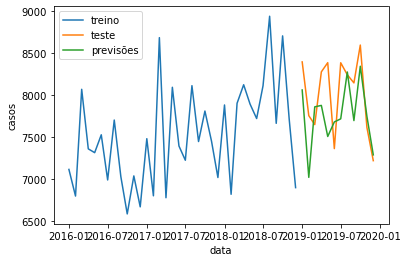

In [22]:
dados_teste['casos_prev'] = modelo_treinado.forecast(12)[0]

sns.lineplot(
    data=dados_treino[-36:],
    x='data',
    y='casos',
    label='treino',
)

sns.lineplot(
    data=dados_teste,
    x='data',
    y='casos',
    label='teste',
)

sns.lineplot(
    data=dados_teste,
    x='data',
    y='casos_prev',
    label='previsões',
)

plt.legend()

plt.show()

Apesar de toda a argumentação que fizemos, o ajuste de modelos deste tipod é bastante complexo e muitas vezes imprevisível. Dessa forma, é sempre prudente explorar mais possibilidades de parâmetros. Da mesma forma, podemos considerar a utilização de um modelo *SARIMA*, onde o *S* indica *sazonalidade*. Neste tipo de modelo, temos mais três parâmtros, *P*, *D* e *Q*, que se referem à componente sazonal da série. Como já observamos que nossa série aparentar ter alguma periodicidade, poderíamos tentar tal modelo.

Para investigar uma série de valores para os parâmetros, a biblioteca *pmdarima* se faz muito útil. Ela possui a função *auto_arima*, que faz a busca pelos melhores parâmetros de forma automática. Vamos então utilizá-la para realizar uma busca, começando pelo valor *p=12*, e admitindo uma sazonalidade com período também de *m=12*. Se o método de busca julgar que é melhor não considerarmos esta periodicidade, os parâmetros sazonais encontrados serão nulos.

In [23]:
modelo_auto_arima = pm.auto_arima(
    dados_treino['casos'],
    start_p=12,
    max_p=20,
    start_q=0,
    max_order=20,
    m=12,
    trace=True,
)

Performing stepwise search to minimize aic
 ARIMA(11,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=7.86 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=3462.510, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=3289.199, Time=0.43 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=3249.086, Time=0.79 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=3460.524, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=3312.298, Time=0.18 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=1.82 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=3246.454, Time=2.59 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=inf, Time=4.60 sec
 ARIMA(0,1,0)(0,0,2)[12] intercept   : AIC=3398.593, Time=1.59 sec
 ARIMA(1,1,1)(0,0,2)[12] intercept   : AIC=3242.479, Time=3.39 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=3246.995, Time=1.14 sec
 ARIMA(1,1,1)(1,0,2)[12] intercept   : AIC=3195.454, Time=5.30 sec
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=1.01 sec
 ARIMA(1,1,1)(2,0,2)[12] intercept   :

Podemos ver que o *auto_arima* encontrou parâmetros bem diferentes dos que tínhamos estimado, graças à utilização da sazonalidade. O gráfico abaixo mostra que os resultados são bastante semelhantes. A linha vertical tracejada separa o período inicial, de treino, do período de teste.

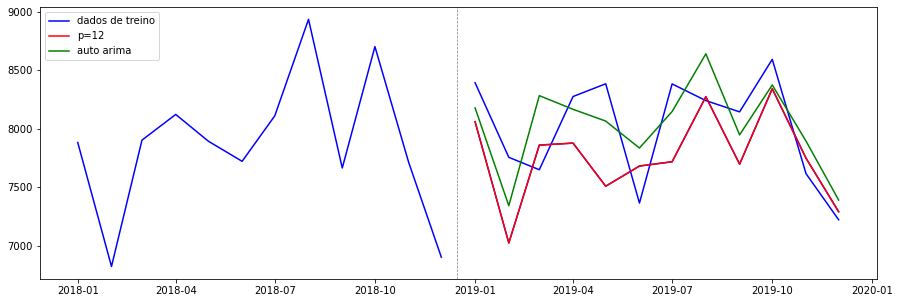

In [24]:
previsoes = pd.DataFrame(
    {'casos': modelo_treinado.forecast(12)[0]},
    index=dados_teste.index,
)

previsoes_auto_arima = pd.DataFrame(
    {'casos': modelo_auto_arima.predict(12)},
    index=dados_teste.index,
)

fig, ax = plt.subplots(figsize=(15, 5))

ax.plot(
    dados_treino[-12:],
    color='blue',
    label='dados de treino',
)

ax.plot(
    dados_teste,
    color='blue',
)

ax.plot(
    previsoes,
    color='red',
    label='p=12',
)

ax.plot(
    previsoes_auto_arima,
    color='green',
    label='auto arima',
)

ax.axvline(datetime(2018, 12, 15), color='gray', ls='--', lw=.7)

plt.legend()

plt.show()

Para julgar qual dos dois modelos é melhor, podemos usar a função *smape* (*symmetric mean absolute percentage error*) do *pmdarima*. Para esta métrica, quanto menor o seu valor, melhor é o modelo. Sendo assim, um valor de 0 indica que o modelo é perfeito. Vemos então que o modelo obtido pelo *auto_arima* é superior por uma pequena margem.

In [25]:
smape_p_12 = smape(dados_teste['casos'], previsoes['casos'])
smape_auto_arima = smape(dados_teste['casos'], previsoes_auto_arima['casos'])

print(
    f'SMAPE do modelo com p=12: {smape_p_12}',
    f'SMAPE do modelo auto_arima: {smape_auto_arima}',
    sep='\n',
)

SMAPE do modelo com p=12: 4.733506744481722
SMAPE do modelo auto_arima: 3.829674403196146


Tendo definido o melhor modelo, agora podemos utilizá-lo para fazer previsões para o futuro.

Vamos primeiro retreinar o nosso modelo usando toda a série temporal.

In [26]:
modelo_auto_arima.fit(serie_temp.squeeze())

ARIMA(order=(1, 1, 1), scoring_args={}, seasonal_order=(1, 0, 2, 12),
      suppress_warnings=True)

Em seguida fazemos a previsão do número de casos de tuberculose para o próximo ano.

In [27]:
previsoes_final = pd.DataFrame(
    {'casos': modelo_auto_arima.predict(12)},
    index=pd.to_datetime([
        f'2020-{m}'
        for m in range(1, 13)
    ]),
)

Finalmente, podemos visualizar o resultado em um gráfico da série temporal completa.

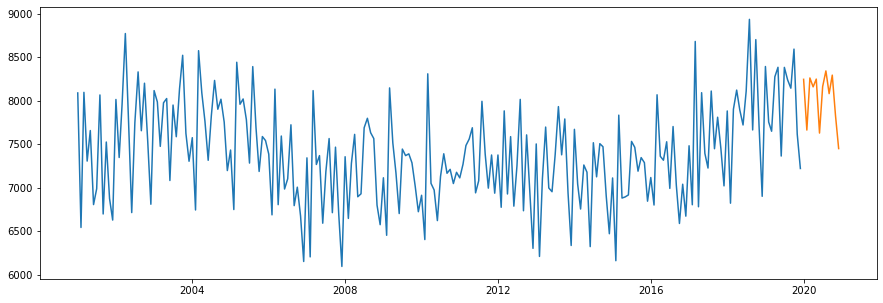

In [28]:
fig, ax = plt.subplots(figsize=(15, 5))

ax.plot(serie_temp)

ax.plot(previsoes_final)

plt.show()